### Story: Recovering a hidden temperature field from hot/cold readings
"
Imagine a 2D grid of true temperatures `T[i, j]` over a surface. The sensors we have are simple: they only tell us whether a location is “hot” (1) or “cold” (0) relative to a threshold. We do not see temperatures directly. Our goal is to reconstruct the continuous temperature field from these binary observations by exploiting the fact that real temperatures vary smoothly across space.


### Generative model (intuition)

- **Latent field**: Continuous temperatures `T[i, j]` that are spatially smooth; neighbors tend to be similar.
- **Observations**: Binary hot/cold readings `y[i, j] ∈ {0,1}` with noise, modeled as `y[i, j] ~ Bernoulli(σ(T[i, j]))`, where `σ` is the logistic function. The threshold can be absorbed into the offset of `T`.
- **Spatial prior**: A pairwise coupling between neighbors that penalizes sharp jumps, encouraging smooth reconstructions unless data strongly suggests boundaries.

In this notebook, we implement the logistic observation via a custom `Sigmoid` node and enforce spatial smoothness using Gaussian couplings between neighboring cells (a Gaussian MRF–like prior).


### What this notebook does

- **Simulates observations**: Loads a smooth grayscale image as a proxy for `T` and produces noisy hot/cold readings via a logistic sensor.
- **Builds the model**: Combines a logistic observation (`Sigmoid`) with a spatial prior coupling neighbors.
- **Performs inference**: Uses variational message passing to approximate the posterior over `T`.
- **Visualizes results**: Compares the binary observations to the recovered continuous temperature field (normalized).


In [1]:
using Distributions, ExponentialFamilyProjection, Images, Plots, ReactiveMP, RxInfer, StableRNGs, StatsFuns

In [2]:
struct Sigmoid end

@node Sigmoid Stochastic [out, x]

@rule Sigmoid(:x, Marginalisation) (q_out::PointMass,) = begin
    y = mean(q_out)
    y = float(mean(q_out))
    sign = 1-2y
    # Provide logpdf, gradient, and Hessian for 1D logistic-Bernoulli
    _logpdf = (out, x) -> (out[] = -softplus(sign * x))
    _grad = (out, x) -> (out[1] = y - logistic(x))
    _hess = (out, x) -> (out[1, 1] = -logistic(x) * (1 - logistic(x)))
    return ExponentialFamilyProjection.InplaceLogpdfGradHess(_logpdf, _grad, _hess)
end

function BayesBase.prod(::GenericProd, left::UnivariateGaussianDistributionsFamily, right::ExponentialFamilyProjection.InplaceLogpdfGradHess)
    m = mean(left)
    σ = var(left)
    combined_logpdf! = (out, x) -> begin
        right.logpdf!(out, x)
        out[] = logpdf(left, x) + out[]
    end
    combined_gradhes! = (out_grad, out_hess, x) -> begin
        out_grad, out_hess = right.grad_hess!(out_grad, out_hess, x)
        out_grad .= out_grad .- ((x .- m) ./ σ)
        out_hess .= out_hess .- 1 / σ
        return out_grad, out_hess
    end
    return ExponentialFamilyProjection.InplaceLogpdfGradHess(combined_logpdf!, combined_gradhes!)
end

function BayesBase.prod(::GenericProd, left::ExponentialFamilyProjection.InplaceLogpdfGradHess, right::UnivariateGaussianDistributionsFamily)
    return prod(GenericProd(), right, left)
end

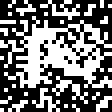

In [3]:
rng = StableRNG(112)
mnist_picture = load("mnist_picture.png")
mnist_picture

sample_matrix = convert(Matrix{Float64}, mnist_picture);
normalized_matrix = (sample_matrix .- mean(sample_matrix))/std(sample_matrix)

observation_matrix = begin 
    o = zeros(28, 28)
    for i in 1:28, j in 1:28
        o[i, j] = rand(rng, Bernoulli(logistic(normalized_matrix[i, j])))
    end
    o
end

Gray.(observation_matrix)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


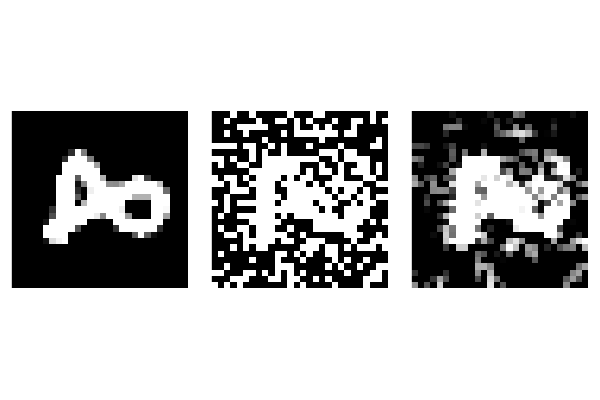

In [6]:
@model function sigmoid_ising(h, w, image)
    # x_extra_prior ~ NormalMeanVariance(0, 1)
    local x
    connection_force = 1
    prior ~ NormalMeanVariance(0, connection_force)
    for i in 1:h, j in 1:w
        x[i, j] ~ NormalMeanVariance(prior, connection_force)
    end 
    for i in 1:h, j in 1:w
        image[i, j] ~ Sigmoid(x[i, j]) 
        if i < h && j < w
           x[i, j] ~ NormalMeanVariance(x[i+1, j], connection_force)
           x[i, j] ~ NormalMeanVariance(x[i, j+1], connection_force)
        end
        if i < h
            x[i, j] ~ NormalMeanVariance(x[i+1, j], connection_force)
        end
        if j < w
            x[i, j] ~ NormalMeanVariance(x[i, j+1], connection_force)
        end
    end
end

# Streaming init & autoupdates
sigmoid_init = @initialization begin
    q(x) = NormalMeanVariance(0.0, 1.0)
    q(prior) = NormalMeanVariance(0.5, 1)
end

binary_constraints = @constraints begin
    q(x) :: ProjectedTo(NormalMeanVariance, parameters = ProjectionParameters(
        tolerance = 1e-8,
        strategy = ExponentialFamilyProjection.GaussNewton(nsamples = 1), # deterministic
    ))
    q(x, prior) = q(x)q(prior)
    q(x) = MeanField()
    # q(x_prior, x, x_extra, x_extra_prior) = q(x_prior)q(x)q(x_extra, x_extra_prior)
end

result = infer(
    model          = sigmoid_ising(h=28, w=28), 
    data           = (image = observation_matrix,),
    returnvars     = KeepEach(),
    # options        = (limit_stack_depth = 100, ),
    iterations     = 5,
    initialization = sigmoid_init,
    constraints    = binary_constraints,
    showprogress   = true
);

sigmoid_outputs = map(mean, result.posteriors[:x][5]);
normalize_sigmoid_outputs = (sigmoid_outputs .- mean(sigmoid_outputs))/std(sigmoid_outputs)

l = @layout [
    grid(1,3)
]
plot_obj = plot(layout=l)
plot!(plot_obj, Gray.(normalized_matrix), subplot=1, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj, Gray.(observation_matrix), subplot=2, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
plot!(plot_obj, Gray.(normalize_sigmoid_outputs), subplot=3, legend=false, framestyle=:none, ticks=nothing, aspect_ratio=:equal)
